![hopsworks_logo](../../images/hopsworks_logo.png)

# Part 01: Load, Engineer & Connect

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/logicalclocks/hopsworks-tutorials/blob/master/fraud_online/1_feature_groups.ipynb)

This is the first part of the quick start series of tutorials about Hopsworks Feature Store. As part of this first module, we will work with data related to credit card transactions. 
The objective of this tutorial is to demonstrate how to work with the **Hopworks Feature Store**  for batch data with a goal of training and deploying a model that can predict fraudulent transactions.

## 🗒️ This notebook is divided in 3 sections:
1. Loading the data and feature engineeing,
2. Connect to the Hopsworks feature store,
3. Create feature groups and upload them to the feature store.

![tutorial-flow](../../images/01_featuregroups.png)


In [1]:
!pip install -U hopsworks --quiet

In [2]:
import numpy as np
import pandas as pd

### First of all we will load the data and do some feature engineering on it.

## <span style="color:#ff5f27;"> 💽 Loading the Data </span>

The data we will use comes from 2 different CSV files:

- `transactions.csv`: events containing information about when a credit card was used, such as a timestamp, location, and the amount spent. A boolean fraud_label variable (True/False) tells us whether a transaction was fraudulent or not.
- `profiles.csv`: credit card user information such as birthdate and city of residence.

In a production system, these CSV files would originate from separate data sources or tables, and probably separate data pipelines. **These files have a common credit card number column cc_num, which you will use later to join features together from the different datasets.**

Now, you can go ahead and load the data.

In [3]:
profiles_df = pd.read_csv("https://repo.hops.works/master/hopsworks-tutorials/data/card_fraud_online/profiles.csv", parse_dates=["birthdate"])
profiles_df.columns = ["name", "gender", "mail", "birthdate", "City", "Country", "cc_num"]
profiles_df = profiles_df[["cc_num", "gender"]]
profiles_df.head(3)

,cc_num,gender
0,4796807885357879,F
1,4529266636192966,F
2,4922690008243953,F


In [4]:
trans_df = pd.read_csv("https://repo.hops.works/master/hopsworks-tutorials/data/card_fraud_online/transactions.csv", parse_dates=["datetime"])
trans_df.head(3)

,tid,datetime,cc_num,category,amount,latitude,longitude,city,country,fraud_label
0,11df919988c134d97bbff2678eb68e22,2022-01-01 00:00:24,4473593503484549,Health/Beauty,62.95,42.30865,-83.48216,Canton,US,0
1,dd0b2d6d4266ccd3bf05bc2ea91cf180,2022-01-01 00:00:56,4272465718946864,Grocery,85.45,33.52253,-117.70755,Laguna Niguel,US,0
2,e627f5d9a9739833bd52d2da51761fc3,2022-01-01 00:02:32,4104216579248948,Domestic Transport,21.63,37.60876,-77.37331,Mechanicsville,US,0


In [5]:
trans_df = trans_df[trans_df.category == "Cash Withdrawal"].reset_index(level=0, drop=True)
trans_df["country"] = trans_df["country"].fillna("US")
profiles_df = profiles_df[profiles_df.cc_num.isin(trans_df.cc_num.unique())].reset_index(level=0, drop=True)

In [6]:
profiles_df.head(5)

,cc_num,gender
0,4796807885357879,F
1,4529266636192966,F
2,4922690008243953,F
3,4848518335893425,M
4,4419981075128775,M


In [7]:
profiles_df.shape

(1000, 2)

In [8]:
trans_df.sort_values(["datetime","cc_num"], inplace=True)

---

## <span style="color:#ff5f27;"> 🛠️ Feature Engineering </span>

Fraudulent transactions can differ from regular ones in many different ways. Typical red flags would for instance be a large transaction volume/frequency in the span of a few hours. It could also be the case that elderly people in particular are targeted by fraudsters. To facilitate model learning we will create additional features based on these patterns. In particular, we will create two types of features:
1. **Features that aggregate data from different data sources**. This could for instance be the age of a customer at the time of a transaction, which combines the `birthdate` feature from `profiles.csv` with the `datetime` feature from `transactions.csv`.
2. **Features that aggregate data from multiple time steps**. An example of this could be the transaction frequency of a credit card in the span of a few hours, which is computed using a window function.

Let's start with the first category.

Now you are ready to start by computing the distance between consecutive transactions, which we will call `loc_delta`.
Here we use the [Haversine distance](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html?highlight=haversine#sklearn.metrics.pairwise.haversine_distances) to quantify the distance between two longitude and latitude coordinates.

In [9]:
from math import radians

# Feature engineering.
trans_df.sort_values("datetime", inplace=True)
trans_df[["longitude", "latitude"]] = trans_df[["longitude", "latitude"]].applymap(radians)

def haversine(long, lat, shift):
    """Compute Haversine distance between each consecutive coordinate in (long, lat)."""

    long_shifted = long.shift(shift)
    lat_shifted = lat.shift(shift)
    long_diff = long_shifted - long
    lat_diff = lat_shifted - lat

    a = np.sin(lat_diff/2.0)**2
    b = np.cos(lat) * np.cos(lat_shifted) * np.sin(long_diff/2.0)**2
    c = 2*np.arcsin(np.sqrt(a + b))

    return c

def time_delta(datetime_value, shift):
    """Compute time difference between each consecutive transaction."""

    time_shifted = datetime_value.shift(shift)
    return time_shifted

trans_df["loc_delta_t_plus_1"] = trans_df.groupby("cc_num")\
    .apply(lambda x : haversine(x["longitude"], x["latitude"], 1))\
    .reset_index(level=0, drop=True)\
    .fillna(0)

trans_df["loc_delta_t_minus_1"] = trans_df.groupby("cc_num")\
    .apply(lambda x : haversine(x["longitude"], x["latitude"], -1))\
    .reset_index(level=0, drop=True)\
    .fillna(0)

trans_df["time_delta_t_plus_1"] = trans_df.groupby("cc_num")\
    .apply(lambda x : time_delta(x["datetime"], 1 ))\
    .reset_index(level=0, drop=True)

trans_df["time_delta_t_minus_1"] = trans_df.groupby("cc_num")\
    .apply(lambda x : time_delta(x["datetime"],  -1))\
    .reset_index(level=0, drop=True)

trans_df["time_delta_t_plus_1"] = (trans_df.datetime - trans_df.time_delta_t_plus_1 )/ np.timedelta64(1, 'D')
trans_df["time_delta_t_minus_1"] = (trans_df.time_delta_t_minus_1 - trans_df.datetime )/ np.timedelta64(1, 'D')
trans_df["time_delta_t_plus_1"] = trans_df.time_delta_t_plus_1.fillna(0)
trans_df["time_delta_t_minus_1"] = trans_df.time_delta_t_minus_1.fillna(0)  

In [10]:
trans_df = trans_df[["tid","datetime","cc_num","category","amount","city","country","fraud_label","loc_delta_t_plus_1", "loc_delta_t_minus_1", "time_delta_t_plus_1", "time_delta_t_minus_1"]]

In [11]:
trans_df.datetime = trans_df.datetime.values.astype(np.int64) // 10 ** 6
trans_df.head()

,tid,datetime,cc_num,category,amount,city,country,fraud_label,loc_delta_t_plus_1,loc_delta_t_minus_1,time_delta_t_plus_1,time_delta_t_minus_1
169514,4c51b54665c7ddb466ea5936f4f3a428,1641024661000,4467360740682089,Cash Withdrawal,77.77,Norco,US,0,0.0,0.000148,0.0,0.333333
167022,4c30185aea2e28e7d9797004710e13c6,1641031422000,4700702588013561,Cash Withdrawal,781.27,Jackson,US,0,0.0,0.000070,0.0,0.416667
60585,1a109febabc5c36409f2caf729e110d3,1641031739000,4205094877256105,Cash Withdrawal,36.25,Bothell,US,0,0.0,0.000108,0.0,0.333333
249651,855eb0f8e7fdb85e9b63c60028ce1d53,1641033294000,4918033532626920,Cash Withdrawal,93.05,Brighton Beach,US,0,0.0,0.000032,0.0,0.250000
203481,b0214ee4d61696adf1149dbaf61fcf2f,1641040494000,4166420904624170,Cash Withdrawal,2.46,Iron River,US,0,0.0,0.000135,0.0,0.250000


In [12]:
trans_df.shape

(365120, 12)

---

> **✂️ Let's reduce size of `trans_df` for better perfomance. Also let's split our `trans_df` into 3 parts - the first one will be used in creating the Feature Group and the rest will be inserted in the existing Feature Group later in this tutorial.**

In [13]:
trans_df1 = trans_df.iloc[:5000]

trans_df2 = trans_df.iloc[5000:7500]

trans_df3 = trans_df.iloc[7500:10000]

---

## <span style="color:#ff5f27;"> 🪄 Creating Feature Groups </span>

A [feature group](https://docs.hopsworks.ai/feature-store-api/latest/generated/feature_group/) can be seen as a collection of conceptually related features. In our case, we will create a feature group for the transaction data and a feature group for the windowed aggregations on the transaction data. Both will have `tid` as primary key, which will allow us to join them when creating a dataset in the next tutorial.

Feature groups can also be used to define a namespace for features. For instance, in a real-life setting we would likely want to experiment with different window lengths. In that case, we can create feature groups with identical schema for each window length. 

Before you can create a feature group you need to connect to our feature store.

In [14]:
import hopsworks

project = hopsworks.login()

fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/164


Connected. Call `.close()` to terminate connection gracefully.


To create a feature group we need to give it a name and specify a primary key. It is also good to provide a description of the contents of the feature group and a version number, if it is not defined it will automatically be incremented to `1`.

In [15]:
trans_fg = fs.get_or_create_feature_group(
    name="trans_fraud_online_fg",
    version=1,
    description="Transaction data",
    primary_key=['cc_num'],
    event_time=['datetime'],
    online_enabled=True
)

Here you have also set `online_enabled=True`, which enables low latency access to the data. A full list of arguments can be found in the [documentation](https://docs.hopsworks.ai/feature-store-api/latest/generated/api/feature_store_api/#create_feature_group).

At this point, you have only specified some metadata for the feature group. It does not store any data or even have a schema defined for the data. To make the feature group persistent you need to populate it with its associated data using the `insert` function.

In [16]:
trans_fg.insert(trans_df1)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/164/fs/106/fg/569


Uploading Dataframe: 0.00% |          | Rows 0/5000 | Elapsed Time: 00:00 | Remaining Time: ?

Launching offline feature group backfill job...
Backfill Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/164/jobs/named/trans_fraud_online_fg_1_offline_fg_backfill/executions


(<hsfs.core.job.Job at 0x2af19ed2820>, None)

#### Click on the hyperlink printed in the cell output above to inspect your feature group in the UI.

#### Or use the Feature Store UI

![fg_open_from_jupyter.gif](../../images/fg_open_from_jupyter.gif)

In [17]:
feature_descriptions = [
    {"name": "tid", "description": "Transaction id"},
    {"name": "datetime", "description": "Transaction time"},
    {"name": "cc_num", "description": "Number of the credit card performing the transaction"},
    {"name": "category", "description": "Expense category"},
    {"name": "amount", "description": "Dollar amount of the transaction"},
    {"name": "city", "description": "City in which the transaction was made"},
    {"name": "country", "description": "Country in which the transaction was made"},
    {"name": "fraud_label", "description": "Whether the transaction was fraudulent or not"},
    {"name": "loc_delta_t_plus_1", "description": "Location of consecutive transaction"},
    {"name": "loc_delta_t_minus_1", "description": "Location of previous transaction"},
    {"name": "time_delta_t_plus_1", "description": "Time of consecutive transaction"},
    {"name": "time_delta_t_minus_1", "description": "Time of previous transaction"},    
]

for desc in feature_descriptions: 
    trans_fg.update_feature_description(desc["name"], desc["description"])

In [18]:
profile_fg = fs.get_or_create_feature_group(
    name="profile_fraud_online_fg",
    version=1,
    description="Credit card holder demographic data",
    primary_key=['cc_num'],
    online_enabled=True
)

In [19]:
profile_fg.insert(profiles_df)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/164/fs/106/fg/572


Uploading Dataframe: 0.00% |          | Rows 0/1000 | Elapsed Time: 00:00 | Remaining Time: ?

Launching offline feature group backfill job...
Backfill Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/164/jobs/named/profile_fraud_online_fg_1_offline_fg_backfill/executions


(<hsfs.core.job.Job at 0x2af1aedc400>, None)

In [20]:
feature_descriptions = [
    {"name": "cc_num", "description": "Number of the credit card performing the transaction"},
    {"name": "gender", "description": "Gender of the credit card holder"},
]

for desc in feature_descriptions: 
    profile_fg.update_feature_description(desc["name"], desc["description"])

---

## <span style="color:#ff5f27;"> 👓 Exploration</span>
In the Hopsworks feature store, the metadata allows for multiple levels of explorations and review. Here we will show a few of those capacities. 

### <span style="color:#ff5f27;"> 🔎 Search</span>
Using the search function in the ui, you can query any aspect of the feature groups, feature_view and training data that was previously created.

### <span style="color:#ff5f27;">📊 Statistics</span>
You can also enable statistics in the feature groups.

In [21]:
# trans_fg = fs.get_feature_group("trans_fraud_online_fg", version = 1)
# trans_fg.statistics_config = {
#     "enabled": True,
#     "histograms": True,
#     "correlations": True
# }

# trans_fg.update_statistics_config()
# trans_fg.compute_statistics()

---

## <span style="color:#ff5f27;"> ⚖️ Great Expectations </span> 

Great Expectations’ built-in library includes more than 50 common Expectations, such as:

    expect_column_values_to_not_be_null

    expect_column_values_to_be_unique

    expect_column_median_to_be_between...

#### You can find more expectations in the [official docs](https://greatexpectations.io/expectations/)


Clean, high quality feature data is of paramount importance to being able to train and serve high quality models. Hopsworks offers integration with [Great Expectations](https://greatexpectations.io/) to enable a smooth data validation workflow.

### `More info` - [here](https://docs.hopsworks.ai/3.0/user_guides/fs/feature_group/data_validation/)

> You can attach at most **one expectation suite** to a Feature Group. It can be done **on creation** or at a **later point in time**. Data validation is an **optional step** and is not required to write to a Feature Group.

---

## <span style="color:#ff5f27;"> 🖥 `UI` approach </span> 

1. Click on the Feature Group section in the navigation menu.
2. Click on New Feature Group if you want to create a brand new Feature Group. If you already created your Feature Group you can use the search bar to find and open it. Select `edit` at the top right corner of page.
3. Scroll down to the `Expectation Suite` section. By clicking on `Add another expectation` one can choose an expectation type from a dropdown menu.  All default kwargs associated to the selected expectation type are populated as a json below the dropdown menu. **Edit the json and click the tick button to save the change locally**.

![fg_edit_expectations.gif](../../images/fg_edit_expectations.gif)

---

## <span style="color:#ff5f27;"> ✔️✔️✖️ Now lets create an Expectation </span> 

Here we have created two expactations that will definitely **Fail**.
![expectations_fraud_online_ui](../../images/expectations_fraud_online_ui.png)


In [22]:
# as we can see, there are some values that are less than 10 and greater than 10000 in this batch of data.
trans_df2.amount.describe()

count     2500.000000
mean       695.279072
std       1866.699829
min          0.020000
25%         30.965000
50%         74.040000
75%        471.607500
max      22062.990000
Name: amount, dtype: float64

---

## <span style="color:#ff5f27;"> 🔄 Validate your data </span> 

In [23]:
# to test our expectation just uncomment and run code below

# trans_fg.insert(trans_df2)

Even in the output of cell above we can see that there is an `exception` during Data validation.

To see more details, please go to your Feature Group in the UI and scroll a little bit down to the corresponding section.

![expectations_fraud_online_res.png](../../images/expectations_fraud_online_res.png)

---

## <span style="color:#ff5f27;"> ⌨️ `Code` approach </span> 

### The same results we can achive without UI. Here is code example.

In [24]:
!pip install -U great_expectations --quiet

In [25]:
import great_expectations as ge

# Create (or import an existing) expectation suite using the Great Expectations library.
expectation_suite = ge.core.ExpectationSuite(
    expectation_suite_name="validate_on_insert_suite"
)

---

## <span style="color:#ff5f27;"> ✔️✔️✖️ Now lets create a couple of Expectations </span> 

<AxesSubplot:>

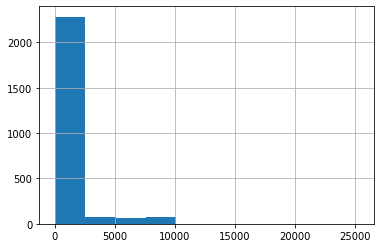

In [26]:
trans_df3.amount.hist()

In [27]:
trans_df3.amount.describe()

count     2500.000000
mean       771.666128
std       2014.293199
min          0.020000
25%         32.965000
50%         75.455000
75%        479.217500
max      25328.740000
Name: amount, dtype: float64

In [28]:
# here we define column to which we gonna apply an expectation
SELECTED_COLUMN = "amount"

In [29]:
# let's for demonstration purposes make the expectation that will definitely fail

# lets add an expecation to the 'amount' column
expectation_suite.add_expectation(
    ge.core.ExpectationConfiguration(
        expectation_type="expect_column_values_to_be_between",
        kwargs={
            "column": SELECTED_COLUMN,
            "min_value": 10,
            "max_value": 100
        }
    )
)

# you can add as many expectations (to different columns in the same time) as you want
expectation_suite.add_expectation(
    ge.core.ExpectationConfiguration(
        expectation_type="expect_column_max_to_be_between",
        kwargs={
            "column": SELECTED_COLUMN,
            "min_value": 0,
            "max_value": 1
        }
    )
)

{"kwargs": {"column": "amount", "min_value": 0, "max_value": 1}, "meta": {}, "expectation_type": "expect_column_max_to_be_between"}

---

> You can provide **'expectation_suite' argument while creating a new Feature Group**. And then **insert new data** like usual, validation will run automatically.

In [30]:
new_feature = fs.get_or_create_feature_group(
    name="test_fg",
    version=1,
    description="Test data",
    primary_key=['index'],
    online_enabled=True,
    # Uncomment below to attach a GE suite when creating this Feature Group
    # expectation_suite=expectation_suite
)

---

### <span style="color:#ff5f27;"> ⬆️ Here we will save an Expectation Suite to the existing Feature Group </span> 

In [31]:
# Using Great Expectations Profiler

ge_profiler = ge.profile.BasicSuiteBuilderProfiler()
expectation_suite_profiler, _ = ge_profiler.profile(ge.from_pandas(trans_df3)) # here we pass a DataFrame to validate

Profiling Columns:   0%|          | 0/12 [00:00<?, ?it/s, tid]

2022-08-12 16:31:49,213 INFO: 	64 expectation(s) included in expectation_suite.


In [32]:
# here we retrieve our 'trans_fraud_online_fg' Feature Group from the Feature Store
trans_fg = fs.get_or_create_feature_group(
    name="trans_fraud_online_fg",
    version=1
)


In [33]:
# lets attach an expectation suite to your Feature Group.
# It enables persistence of the expectation suite to the Hopsworks backend.
trans_fg.save_expectation_suite(expectation_suite)

Attached expectation suite to featuregroup, edit it at https://c.app.hopsworks.ai:443/p/164/fs/106/fg/569


Here they are

![expectations_fraud_online_ui.png](../../images/expectations_fraud_online_ui.png)

> **❗️ Note that the expectation suite object is modified in place to populate it with necessary information to further upload validation reports. This suite can easily be retrieved during a different session or deleted whenever you are working with this Feature Group by calling:**

In [34]:
# we can retrieve the expectation suite very simply
ge_expectation_suite = trans_fg.get_expectation_suite()
ge_expectation_suite

{
  "meta": {
    "great_expectations_version": "0.14.3"
  },
  "ge_cloud_id": null,
  "data_asset_type": null,
  "expectation_suite_name": "validate_on_insert_suite",
  "expectations": [
    {
      "kwargs": {
        "column": "amount",
        "min_value": 10,
        "max_value": 100
      },
      "meta": {
        "expectationId": 169
      },
      "expectation_type": "expect_column_values_to_be_between"
    },
    {
      "kwargs": {
        "column": "amount",
        "min_value": 0,
        "max_value": 1
      },
      "meta": {
        "expectationId": 170
      },
      "expectation_type": "expect_column_max_to_be_between"
    }
  ]
}

In [35]:
# or delete with
# trans_fg.drop_expectation_suite()

---

### <span style="color:#ff5f27;"> 🔄 Validate your data </span> 

In [36]:
# As validation objects returned by Hopsworks are native Great Expectation objects, 
# you can run validation using the usual Great Expectations syntax:
ge_df = ge.from_pandas(trans_df3, expectation_suite=trans_fg.get_expectation_suite())
ge_report = ge_df.validate()

2022-08-12 16:31:50,231 INFO: 	2 expectation(s) included in expectation_suite.


> **❗️ Note that you should always use an expectation suite that has been saved to Hopsworks if you intend to upload the associated validation report. You can use a convenience wrapper method provided by Hopsworks to validate using the attached suite:**

In [37]:
#This will run the validation using the expectation suite attached to this Feature Group
# and raise an exception if no attached suite is found.
ge_report = trans_fg.validate(trans_df3)

# set the save_report parameter to False to skip uploading the report to Hopsworks
# ge_report = fg.validate(df, save_report=False)

2022-08-12 16:31:50,452 INFO: 	2 expectation(s) included in expectation_suite.


---

### <span style="color:#ff5f27;"> ⬆️ Upload Validation Reports to Hopsworks</span> 

When running validation using `Great Expectations`, a **validation report** is generated containing all validation results for the different expectations. Each result provides information about whether the provided DataFrame conforms to the corresponding expectation. These reports can be stored in Hopsworks to save a validation history for the data written to a particular Feature Group.

In [38]:
trans_fg.save_validation_report(ge_report)

Validation Report saved successfully, explore a summary at https://c.app.hopsworks.ai:443/p/164/fs/106/fg/569


{
  "statistics": {
    "evaluated_expectations": 2,
    "successful_expectations": 0,
    "unsuccessful_expectations": 2,
    "success_percent": 0.0
  },
  "evaluation_parameters": {},
  "success": false,
  "meta": {
    "great_expectations_version": "0.14.3",
    "expectation_suite_name": "validate_on_insert_suite",
    "run_id": {
      "run_name": null,
      "run_time": "2022-08-12T14:31:50.452497+00:00"
    },
    "batch_kwargs": {
      "ge_batch_id": "80d2b383-1a4b-11ed-b4bd-14abc5f42df5"
    },
    "batch_markers": {},
    "batch_parameters": {},
    "validation_time": "20220812T143150.452497Z",
    "expectation_suite_meta": {
      "great_expectations_version": "0.14.3"
    }
  },
  "results": [
    {
      "success": false,
      "meta": {},
      "result": {
        "element_count": 2500,
        "missing_count": 0,
        "missing_percent": 0.0,
        "unexpected_count": 1181,
        "unexpected_percent": 47.24,
        "unexpected_percent_total": 47.24,
        "unexp

A summary of these reports is available via an API call or in the Hopsworks UI enabling easy monitoring.

![expectations_fraud_online_res.png](../../images/expectations_fraud_online_res.png)

In [39]:
# For in-depth analysis, it is possible to download the complete report from the UI.

# convenience method for rapid development
ge_latest_report = trans_fg.get_latest_validation_report()
# fetching the latest summary prints a link to the UI 
# where you can download full report if summary is insufficient

Long reports can be truncated when fetching from Hopsworks.
        
You can download the full report at https://c.app.hopsworks.ai:443/p/164/fs/106/fg/569


In [40]:
ge_latest_report

{
  "statistics": {
    "evaluated_expectations": 2,
    "successful_expectations": 0,
    "unsuccessful_expectations": 2,
    "success_percent": 0.0
  },
  "evaluation_parameters": {},
  "success": false,
  "meta": {
    "great_expectations_version": "0.14.3",
    "expectation_suite_name": "validate_on_insert_suite",
    "run_id": {
      "run_name": null,
      "run_time": "2022-08-12T14:31:50.452497+00:00"
    },
    "batch_kwargs": {
      "ge_batch_id": "80d2b383-1a4b-11ed-b4bd-14abc5f42df5"
    },
    "batch_markers": {},
    "batch_parameters": {},
    "validation_time": "20220812T143150.452497Z",
    "expectation_suite_meta": {
      "great_expectations_version": "0.14.3"
    }
  },
  "results": [
    {
      "success": false,
      "meta": {},
      "result": {
        "element_count": 2500,
        "missing_count": 0,
        "missing_percent": 0.0,
        "unexpected_count": 1181,
        "unexpected_percent": 47.24,
        "unexpected_percent_total": 47.24,
        "unexp

---

## <span style="color:#ff5f27;">⏭️ **Next:** Part 02 </span>

In the following notebook you will use our feature groups to create a dataset you can train a model on.